# Disease prediction from microbiome structure using ML

In [97]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore
import random

In [151]:
# # Download abundance data from GMrepo

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "superkingdom2descendents.txt.gz")
# print("taxonomy table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "samples_loaded.txt.gz")
# print("sample table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample_to_run_info.txt.gz")
# print("sample run download finished)
      
# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "species_abundance.txt.gz")
# print("abundance table download finished)

In [32]:
#import data

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype = 'str')

In [33]:
# using only genus for this project

abundance_genus  = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

In [34]:
# reformat: rownames are samples and colnames are taxa

pivoted_df = abundance_genus.pivot_table(index='loaded_uid', columns='ncbi_taxon_id', values='relative_abundance', fill_value=0)

In [35]:
# rename colnames with actual genus names

# Replace blanks with underscores in the scientific_name column
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')

# Create a mapping between ncbi_taxon_id and scientific_name
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))

# Rename columns in pivoted_df based on the mapping
pivoted_df.rename(columns=mapping, inplace=True)

In [36]:
pivoted_df #taxonomy table is incomplete... must complete later with newer ncbi tax tables

ncbi_taxon_id,-1,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
1,0.29633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.36680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.13739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.32762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52855,9.70667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52856,1.01729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52857,3.61897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#merge metadata into a single df

metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

In [38]:
metadata_df

,checking,project_id,our_project_id,sample_name,original_sample_description,curated_sample_description,run_id,sample_id,second_sample_id,experiment_type,...,Antibiotics.Dose,Days.Without.Antibiotics.Use,uid,accession_id,data_type,tool_used,results_version,last_updated,QCStatus,QCMessage
0,1,PRJDB4360,NaN,Japanese001,Healthy Japanese gut microbiota,NaN,DRR048993,NaN,SAMD00042843,Amplicon,...,NaN,NaN,6339,DRR048993,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
1,1,PRJDB4360,NaN,Japanese002,Healthy Japanese gut microbiota,NaN,DRR048994,NaN,SAMD00042844,Amplicon,...,NaN,NaN,6340,DRR048994,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
2,1,PRJDB4360,NaN,Japanese003,Healthy Japanese gut microbiota,NaN,DRR048995,NaN,SAMD00042845,Amplicon,...,NaN,NaN,6341,DRR048995,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
3,1,PRJDB4360,NaN,Japanese004,Healthy Japanese gut microbiota,NaN,DRR048996,NaN,SAMD00042846,Amplicon,...,NaN,NaN,6342,DRR048996,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
4,1,PRJDB4360,NaN,Japanese005,Healthy Japanese gut microbiota,NaN,DRR048997,NaN,SAMD00042847,Amplicon,...,NaN,NaN,6343,DRR048997,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,1,PRJNA215106,NaN,F34_CY,Functional metagenomic selections were perform...,NaN,SRR961853,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6008,SRR961853,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53304,1,PRJNA215106,NaN,F34_PE,Functional metagenomic selections were perform...,NaN,SRR961854,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6060,SRR961854,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53305,1,PRJNA215106,NaN,F34_TE,Functional metagenomic selections were perform...,NaN,SRR961855,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,7342,SRR961855,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53306,1,PRJNA215106,NaN,F34_TR,Functional metagenomic selections were perform...,NaN,SRR961856,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6054,SRR961856,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN


### Data cleaning

In [39]:
## metadata cleaning

# 1) Remove rows where QCStatus is equal to 0 (didn't pass quality filter)
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]

# 2) Remove rows with a phenotype value_count < 100 (too few samples for robust ML)
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]

# 3) rename healthy, health and Normal to Healthy; rename IBD synonyms
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['healthy', 'Health', 'Normal'], 'Healthy')
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['IBD', 'Inflamatory Bowel Diseases'], 'Inflamatory Bowel Disease')

# 4) Find and remove duplicated rows (excluding the 'phenotype' column)

#duplicated uids to filter from abundance table
non_phenotype_columns = metadata_df.columns.difference(['phenotype'])

duplicated_uids = metadata_df[metadata_df.duplicated(subset=non_phenotype_columns, keep=False)]['uid']
duplicated_uids = duplicated_uids.unique()

duplicated_rows = metadata_df.duplicated(subset=non_phenotype_columns, keep=False)
metadata_df = metadata_df[~duplicated_rows]

In [40]:
## abundance cleaning

# 1) exclude data uids from the abundance table that are not in the metadata table
uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[uids_to_keep]

# 2) remove unknown column
pivoted_df_filtered = pivoted_df_filtered.iloc[:, 1:]

In [41]:
# check

if len(metadata_df) == len(pivoted_df_filtered) and (metadata_df["uid"] == pivoted_df_filtered.index).all():
    print("\nMetadata and abundance tables are the same length and have the same content in the same order 👍\n")
else:
    print("\ngrab a coffee\n")


Metadata and abundance tables are the same length and have the same content in the same order 👍



In [42]:
#reset indexes for future compatibility

metadata_df = metadata_df.reset_index(drop=True)
pivoted_df_filtered = pivoted_df_filtered.reset_index(drop=True)

In [43]:
pivoted_df_filtered

ncbi_taxon_id,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,Cystobacter,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.005849,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27576,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27577,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27578,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27579,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


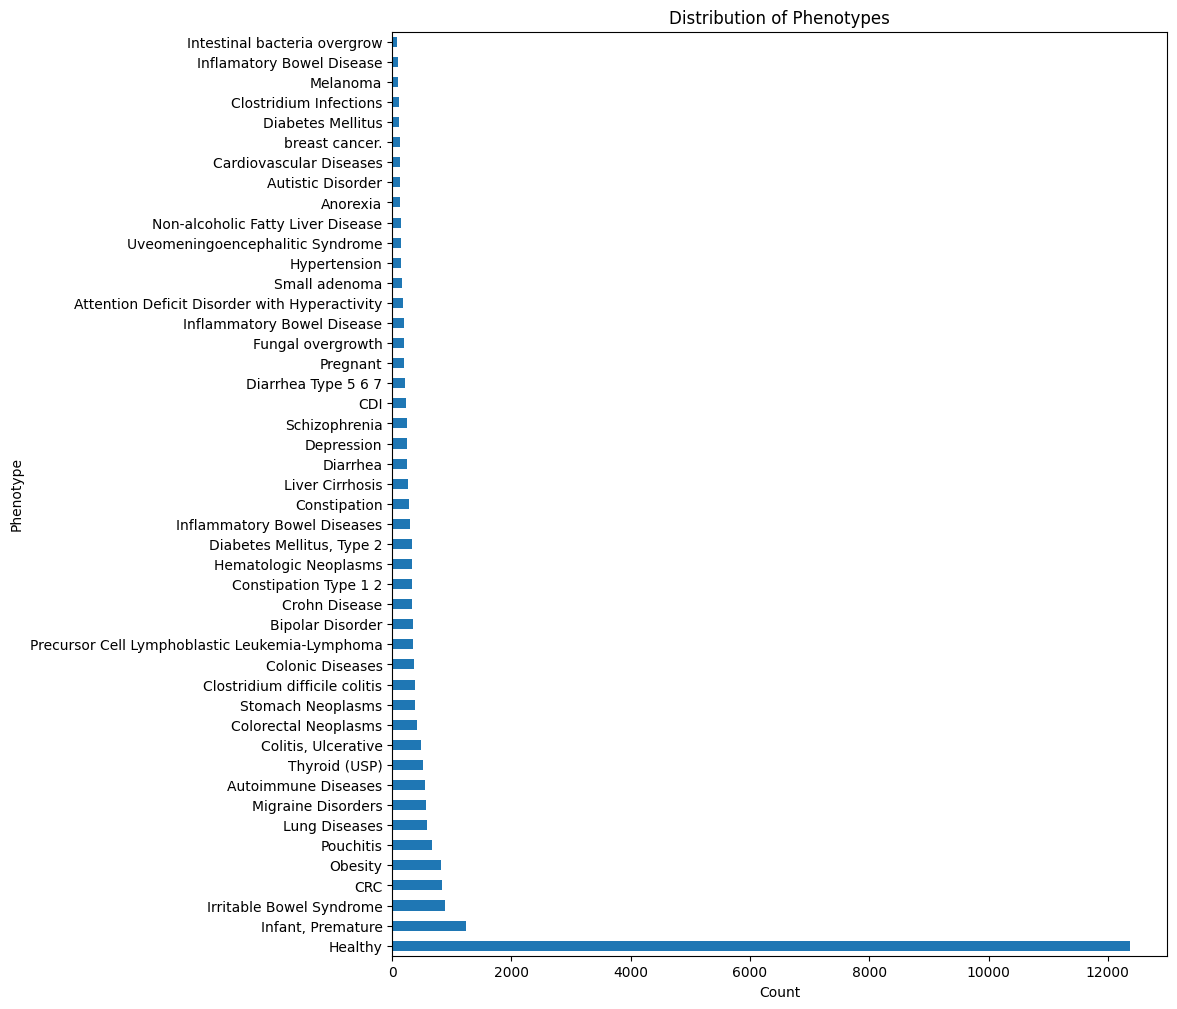

In [44]:
#plot remaining categories

plt.figure(figsize=(10, 12))

metadata_df['phenotype'].value_counts().plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Phenotype')
plt.title('Distribution of Phenotypes')

plt.show()

### PCA of healthy samples

In [45]:
#subset healthy samples from both dfs

healthy_metadata = metadata_df[metadata_df["phenotype"] == "Healthy"]
pivoted_df_Healthy = pivoted_df_filtered.loc[healthy_metadata.index] #use healthy_metadata index to subset pivoted_df_filtered by the index

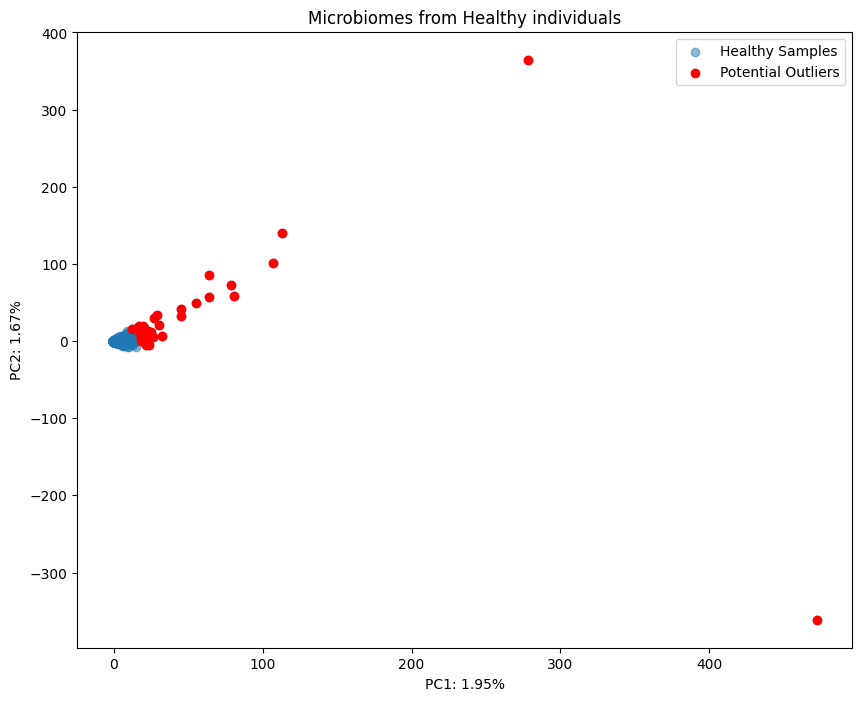

In [46]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Calculate Z-scores for each PC
z_scores = zscore(pca_df)

# Set a threshold for Z-scores to identify outliers (e.g., threshold = 3)
outlier_threshold = 3
outliers = (z_scores > outlier_threshold).any(axis=1)

# Identify outlier samples
outlier_samples = pca_df[outliers]

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')
plt.scatter(outlier_samples['PC1'], outlier_samples['PC2'], color='red', label='Potential Outliers')

plt.legend()
plt.show()


In [47]:
outliers

0        False
1        False
2        False
3        False
4        False
         ...  
12371    False
12372    False
12373    False
12374    False
12375    False
Length: 12376, dtype: bool

In [50]:
# Reset the index on outliers Series
outliers_reset = outliers.reset_index(drop=True)


# Filter rows in both DataFrames based on outliers_reset Series
pivoted_df_Healthy = pivoted_df_Healthy_reset[~outliers_reset]
healthy_metadata = healthy_metadata_reset[~outliers_reset]

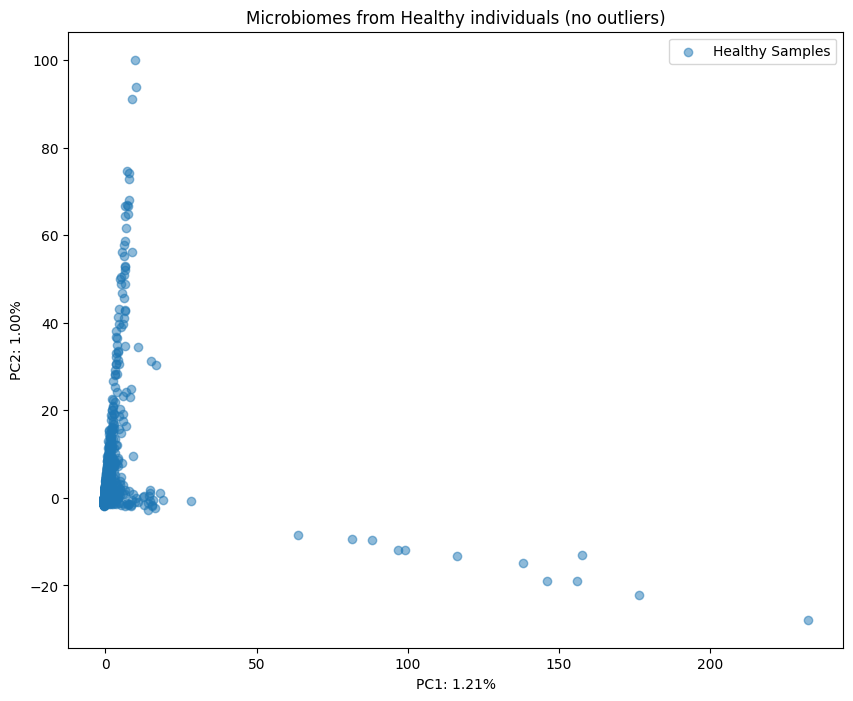

In [51]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals (no outliers)')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')

plt.legend()
plt.show()


### PCA  

In [54]:
#subset healthy samples from both dfs

non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"]
pivoted_df_non_Healthy = pivoted_df_filtered.loc[non_healthy_metadata.index] #use non_healthy_metadata index to subset pivoted_df_filtered by the index

In [62]:
# phenotypes

# Separate labels into "Healthy" and "Non-Healthy"

phenotype_labels_healthy = healthy_metadata[["phenotype", "uid"]]
healthy_labels = phenotype_labels[phenotype_labels["phenotype"] == "Healthy"]

phenotype_labels_non_healthy = non_healthy_metadata[["phenotype", "uid"]]
non_healthy_labels = phenotype_labels[phenotype_labels["phenotype"] != "Healthy"]

In [81]:
# Reset indexes
phenotype_labels_healthy = phenotype_labels_healthy.reset_index(drop=True)
pivoted_df_non_Healthy = pivoted_df_non_Healthy.reset_index(drop=True)
phenotype_labels_non_healthy = phenotype_labels_non_healthy.reset_index(drop=True)
non_healthy_labels = non_healthy_labels.reset_index(drop=True)

In [82]:
pivoted_df_non_Healthy

ncbi_taxon_id,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,Cystobacter,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012595,0.0
15201,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011003,0.055018,0.0
15202,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
15203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [92]:
pca_df_with_labels

,PC1,PC2,phenotype,phenotype_encoded
0,-1.630713,0.289777,Bipolar Disorder,4
1,-1.630713,0.289777,Depression,16
2,-1.630713,0.289777,Fungal overgrowth,21
3,-1.630713,0.289777,Lung Diseases,31
4,-1.630713,0.289777,Schizophrenia,39
...,...,...,...,...
15200,-1.429710,0.077380,Crohn Disease,15
15201,-1.370118,-0.050822,Crohn Disease,15
15202,-1.517628,0.135290,Crohn Disease,15
15203,-1.830246,0.361784,Crohn Disease,15


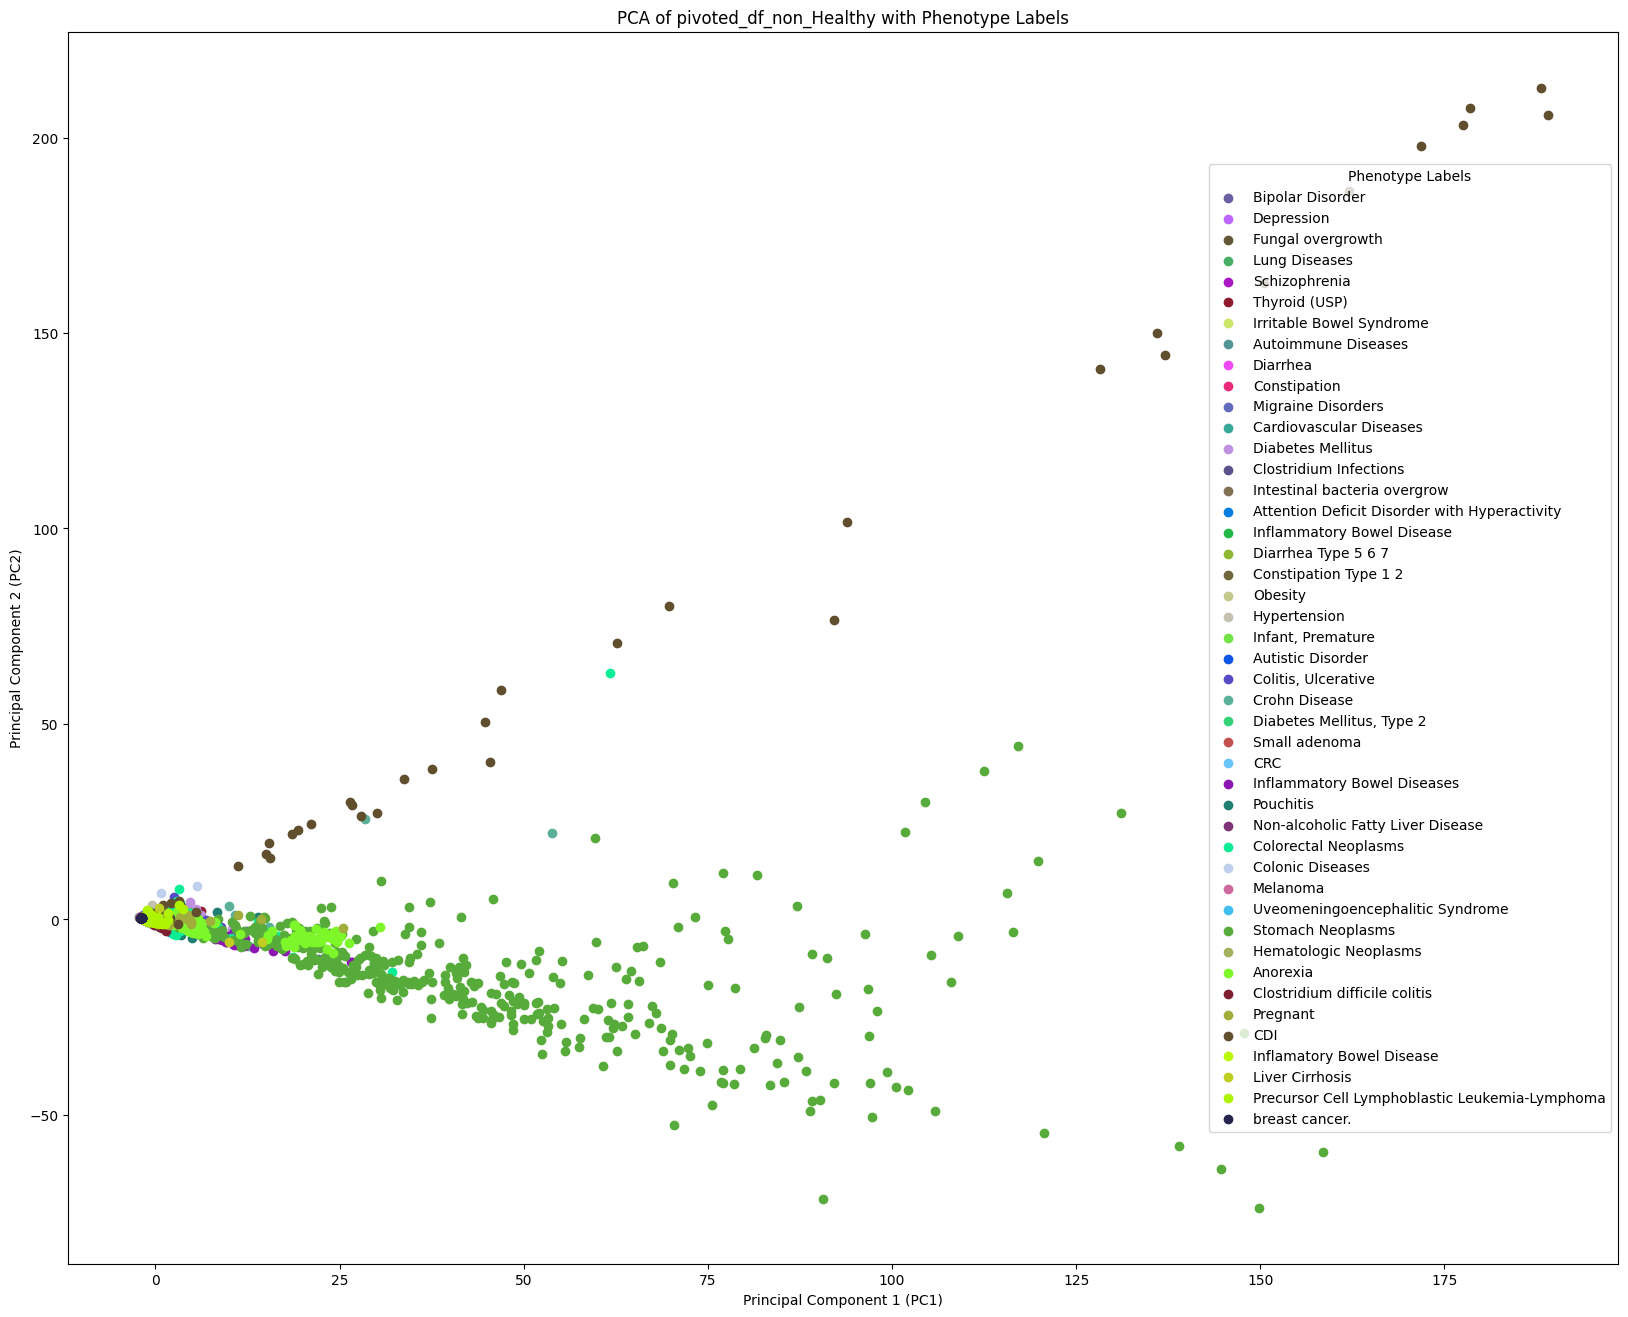

In [96]:
# Convert column names to strings
pivoted_df_non_Healthy.columns = pivoted_df_non_Healthy.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
pivoted_df_non_Healthy_standardized = scaler.fit_transform(pivoted_df_non_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_non_Healthy_standardized)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with labels
pca_df_with_labels = pd.concat([pca_df, phenotype_labels_non_healthy['phenotype']], axis=1)

# Use unique labels as categories
unique_labels = pca_df_with_labels['phenotype'].unique()

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]

# Create a color mapping for each unique label
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}


# Plot the PCA results with labels and colors
plt.figure(figsize=(20, 16))
for label, color in label_colors.items():
    subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color)

plt.title('PCA of pivoted_df_non_Healthy with Phenotype Labels')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='Phenotype Labels')
plt.show()
